📥 Loading datasets...
  ✓ Loaded SO2_v=1: (8000, 21)
  ✓ Loaded SO2_v=10: (801, 21)
  ✓ Loaded SO2_v=20: (401, 21)

🚀 Training models...

SO2_v=1:
  ✓ MSE: 0.1341, RMSE: 0.3662, MAE: 0.2285, R²: 0.9845, MAPE: 0.91%, GME: 1.0092

SO2_v=10:
  ✓ MSE: 1.1956, RMSE: 1.0935, MAE: 0.8347, R²: 0.8597, MAPE: 3.57%, GME: 1.0361

SO2_v=20:
  ✓ MSE: 1.2869, RMSE: 1.1344, MAE: 0.8384, R²: 0.8555, MAPE: 3.65%, GME: 1.0366

📊 Plotting prediction results...


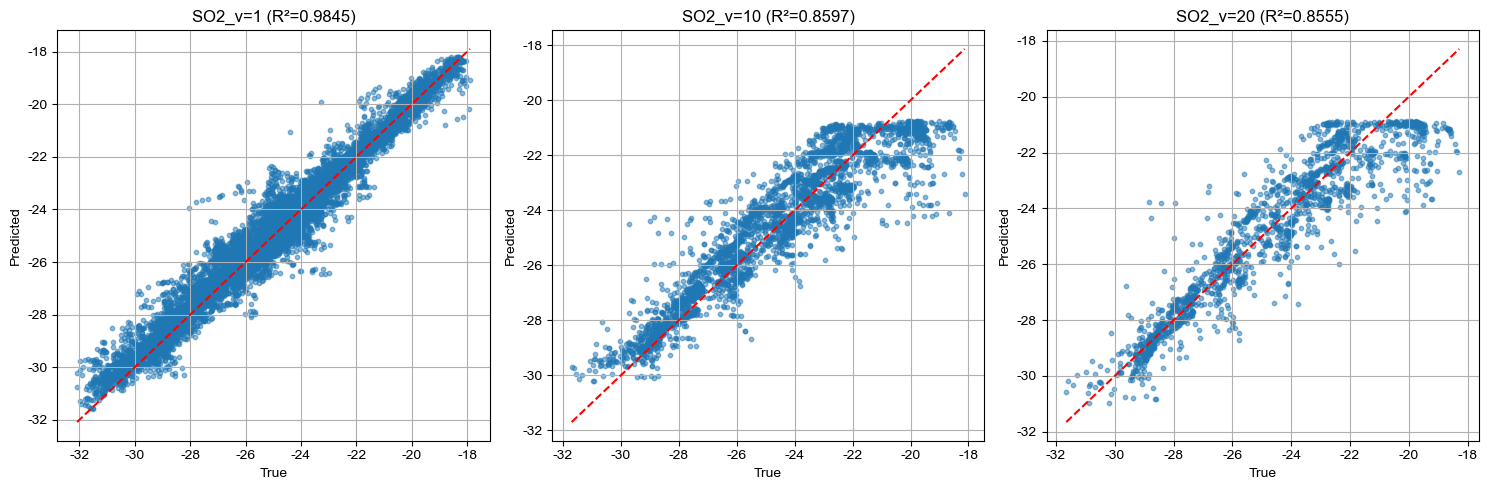

  ✓ Saved: so2_model_predictions.png


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 🔧 Tool functions: building pipelines with polynomials and normalisation
def make_poly_mlp(model, degree=2):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        model
    )

# 🌟 main category
class SO2DataAnalyzer:
    def __init__(self):
        self.datasets = {}
        self.results = {}

    def load_data(self):
        print("📥 Loading datasets...")
        file_paths = {
            'SO2_v=1': 'so2_v=1.xlsm',
            'SO2_v=10': 'so2_v=10.xlsm', 
            'SO2_v=20': 'so2_v=20.xlsm'
        }
        for name, path in file_paths.items():
            try:
                df = pd.read_excel(path)
                self.datasets[name] = df
                print(f"  ✓ Loaded {name}: {df.shape}")
            except Exception as e:
                print(f"  ✗ Failed to load {name}: {e}")
                return False
        return True

    def preprocess_data(self):
        for name, df in self.datasets.items():
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.fillna(method='ffill', inplace=True)
            df.fillna(method='bfill', inplace=True)
            self.datasets[name] = df

    def train_models(self):
        print("\n🚀 Training models...")
        for name, df in self.datasets.items():
            print(f"\n{name}:")

            try:
                wavenumber_col = df.columns[0]
                temp_cols = [col for col in df.columns if col.startswith('t=')]

                X, y = [], []
                for _, row in df.iterrows():
                    wavenumber = row[wavenumber_col]
                    for temp_col in temp_cols:
                        temp = int(temp_col.replace('t=', '').replace('k', ''))
                        value = row[temp_col]
                        if not np.isnan(value) and value > 0:
                            X.append([wavenumber, temp])
                            y.append(np.log10(value))

                X = np.array(X)
                y = np.array(y)

                if len(X) == 0:
                    print("  ✗ No valid data")
                    continue

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                model = make_poly_mlp(
                    MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000, random_state=1),
                    degree=2
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
                gme = np.exp(np.mean(np.abs(np.log(np.abs(y_test + 1e-10)) - np.log(np.abs(y_pred + 1e-10)))))

                self.results[name] = {
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'mape': mape,
                    'gme': gme
                }

                print(f"  ✓ MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%, GME: {gme:.4f}")

            except Exception as e:
                print(f"  ✗ Error during training: {e}")

    def plot_results(self):
        print("\n📊 Plotting prediction results...")
        plt.figure(figsize=(15, 5))
        for i, (name, result) in enumerate(self.results.items()):
            plt.subplot(1, 3, i + 1)
            plt.scatter(result['y_test'], result['y_pred'], alpha=0.5, s=10)
            plt.plot([min(result['y_test']), max(result['y_test'])],
                     [min(result['y_test']), max(result['y_test'])], 'r--')
            plt.xlabel('True')
            plt.ylabel('Predicted')
            plt.title(f'{name} (R²={result["r2"]:.4f})')
            plt.grid(True)
        plt.tight_layout()
        plt.savefig("so2_model_predictions.png", dpi=300)
        plt.show()
        print("  ✓ Saved: so2_model_predictions.png")

    def run(self):
        if not self.load_data():
            print("❌ Cannot proceed without data.")
            return
        self.preprocess_data()
        self.train_models()
        self.plot_results()

if __name__ == "__main__":
    analyzer = SO2DataAnalyzer()
    analyzer.run()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e+04, tolerance: 1.280e+01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+03, tolerance: 1.282e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+03, toler

    Dataset       MSE      RMSE       MAE            R2
0   so2 v=1  2.244312  1.498103  1.442098 -4.716087e+39
1  so2 v=10  2.141162  1.463271  1.407291 -4.519370e+39
2  so2 v=20  2.039747  1.428197  1.368085 -4.348842e+39


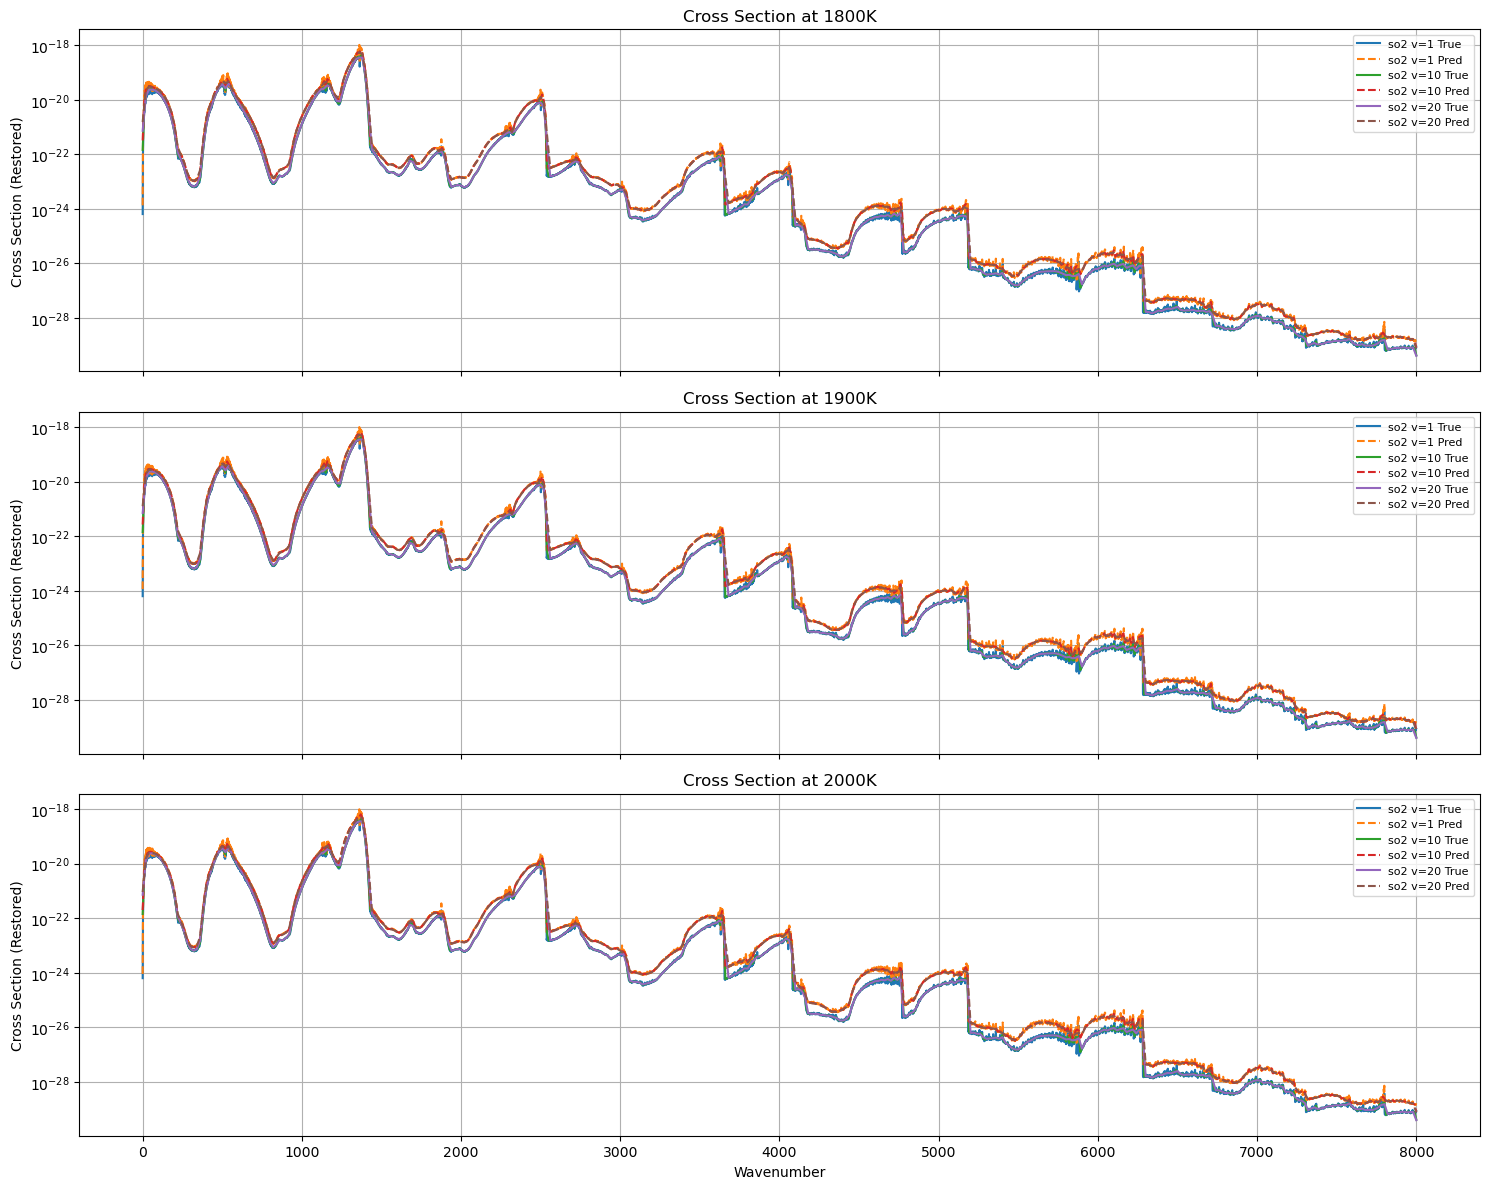

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== Data set path ==========
datasets = {
    'so2 v=1': 'so2_v=1.xlsm',
    'so2 v=10': 'so2_v=10.xlsm',
    'so2 v=20': 'so2_v=20.xlsm'
}

# ========== Defining function: normalisation + training + prediction + back-normalisation==========
def process_dataset(name, file):
    # 读取数据
    df = pd.read_excel(file)
    df = df.rename(columns={'number': 'wavenumber'})
    
    # Divide training/testing (1800, 1900, 2000K for testing)
    columns_to_exclude = ['t=1800k', 't=1900k', 't=2000k']
    columns_to_normalize = [col for col in df.columns if col.startswith('t=') and col not in columns_to_exclude]

    # standardisation by bank
    data_to_normalize = df[columns_to_normalize].copy()
    row_means = data_to_normalize.mean(axis=1)
    row_stds = data_to_normalize.std(axis=1)
    df_scaled = (data_to_normalize.subtract(row_means, axis=0)).divide(row_stds, axis=0)

    #Save statistics
    df_stats = pd.DataFrame({
        'wavenumber': df['wavenumber'],
        'row_mean': row_means,
        'row_std': row_stds
    }).set_index('wavenumber')

    # Training data after splicing normalisation
    train_df = pd.concat([df[['wavenumber']], df_scaled], axis=1)

    # growth chart
    long_df = pd.melt(
        train_df,
        id_vars='wavenumber',
        value_vars=[col for col in train_df.columns if col.startswith('t=')],
        var_name='temperature',
        value_name='cross_section'
    )
    long_df['temperature'] = long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    # Training/test set division
    test_df = df[['wavenumber'] + columns_to_exclude].rename(columns={'number': 'wavenumber'})
    test_long_df = pd.melt(
        test_df,
        id_vars='wavenumber',
        value_vars=columns_to_exclude,
        var_name='temperature',
        value_name='cross_section'
    )
    test_long_df['temperature'] = test_long_df['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)

    X_train, y_train = long_df[['wavenumber', 'temperature']], long_df['cross_section']
    X_test, y_test = test_long_df[['wavenumber', 'temperature']], test_long_df['cross_section']

    # modelling
    model = make_pipeline(
        PolynomialFeatures(degree=6, include_bias=False),
        Lasso(alpha=1.0, max_iter=5000)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Save predictions
    test_long_df['predicted'] = y_pred

    # inverse normalisation
    cross_section_restored = []
    predicted_restored = []
    for idx, row in test_long_df.iterrows():
        wnum = row['wavenumber']
        mean = df_stats.loc[wnum, 'row_mean']
        std = df_stats.loc[wnum, 'row_std']
        cs_restored = row['cross_section'] * std + mean
        pred_restored = row['predicted'] * std + mean
        cross_section_restored.append(cs_restored)
        predicted_restored.append(pred_restored)

    test_long_df['cross_section_restored'] = cross_section_restored
    test_long_df['predicted_restored'] = predicted_restored

    # Calculation of error indicators
    mse = mean_squared_error(test_long_df['cross_section'], test_long_df['predicted'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_long_df['cross_section'], test_long_df['predicted'])
    r2 = r2_score(test_long_df['cross_section'], test_long_df['predicted'])

    metrics = {'Dataset': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return test_long_df, metrics

# ========== Loop through all data sets ==========
results = {}
metrics_list = []
for name, file in datasets.items():
    df_result, metric = process_dataset(name, file)
    results[name] = df_result
    metrics_list.append(metric)

# Printing Error Indicator
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# ========== draw a comparison chart ==========
temps = [1800, 1900, 2000]
fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

for i, temp in enumerate(temps):
    ax = axs[i]
    for name, df in results.items():
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label=f'{name} True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label=f'{name} Pred')
    ax.set_title(f'Cross Section at {temp}K')
    ax.set_ylabel('Cross Section (Restored)')
    ax.legend(fontsize=8)
    ax.grid(True)
    ax.set_yscale('log')

axs[-1].set_xlabel('Wavenumber')
plt.tight_layout()
plt.show()

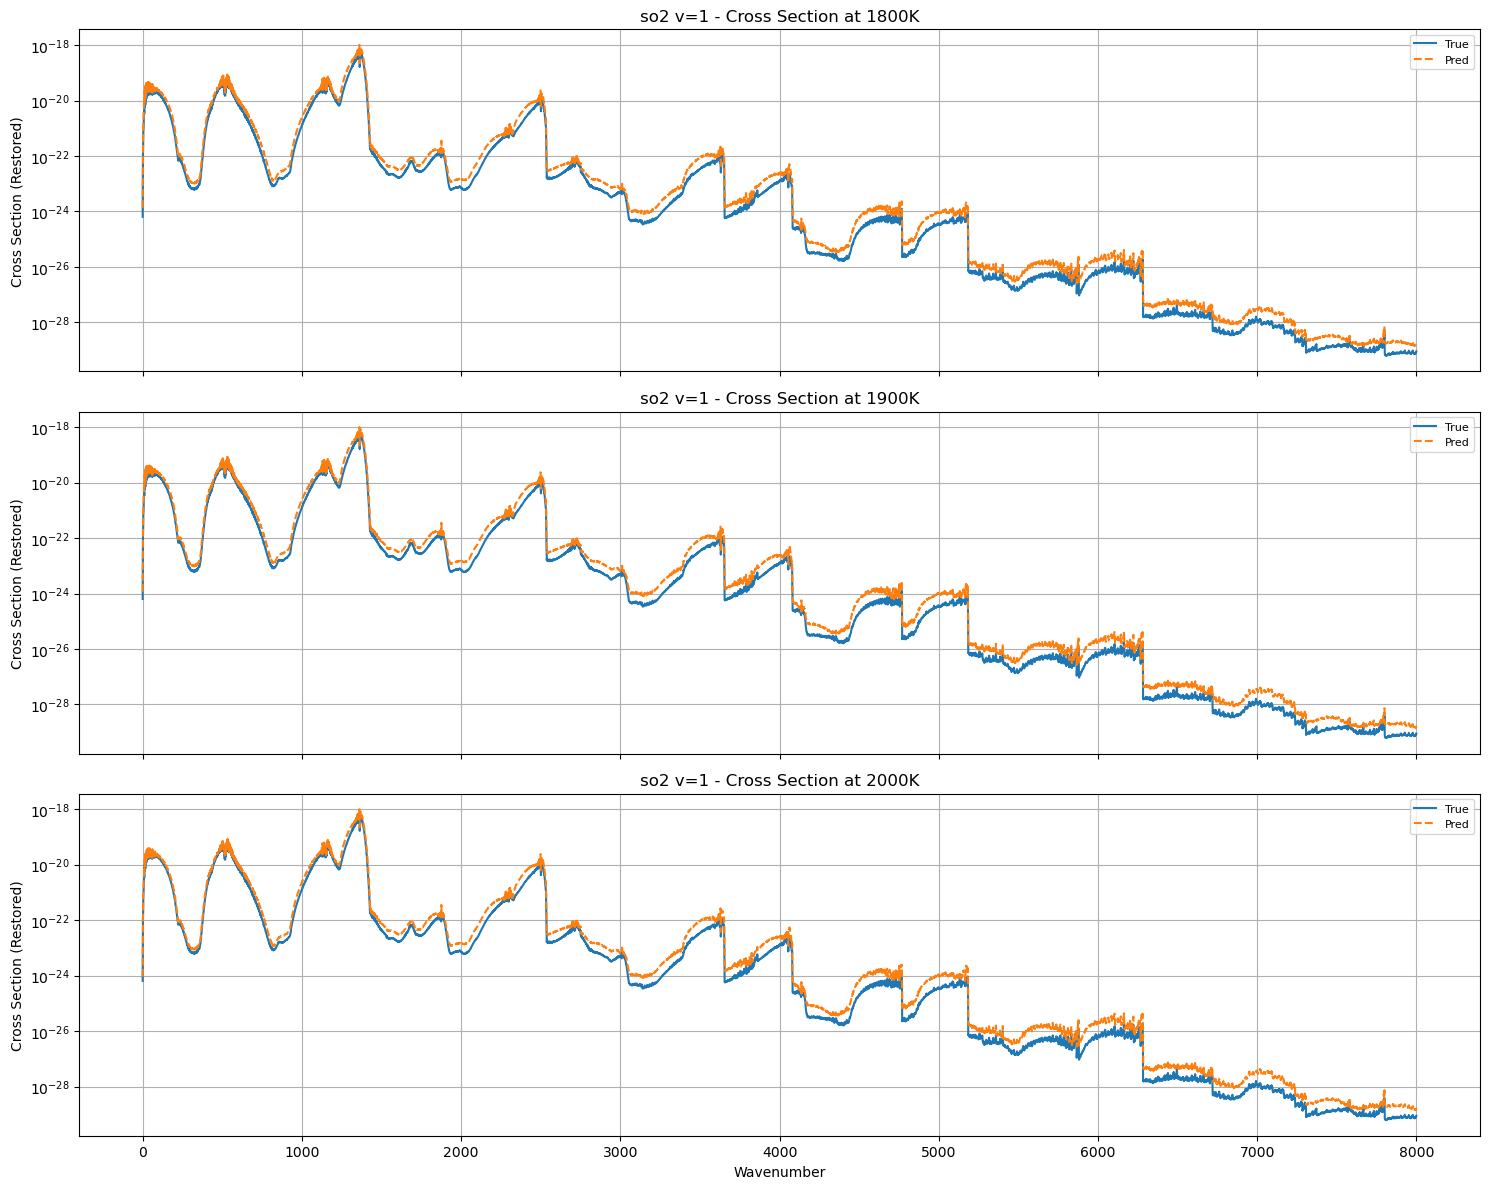

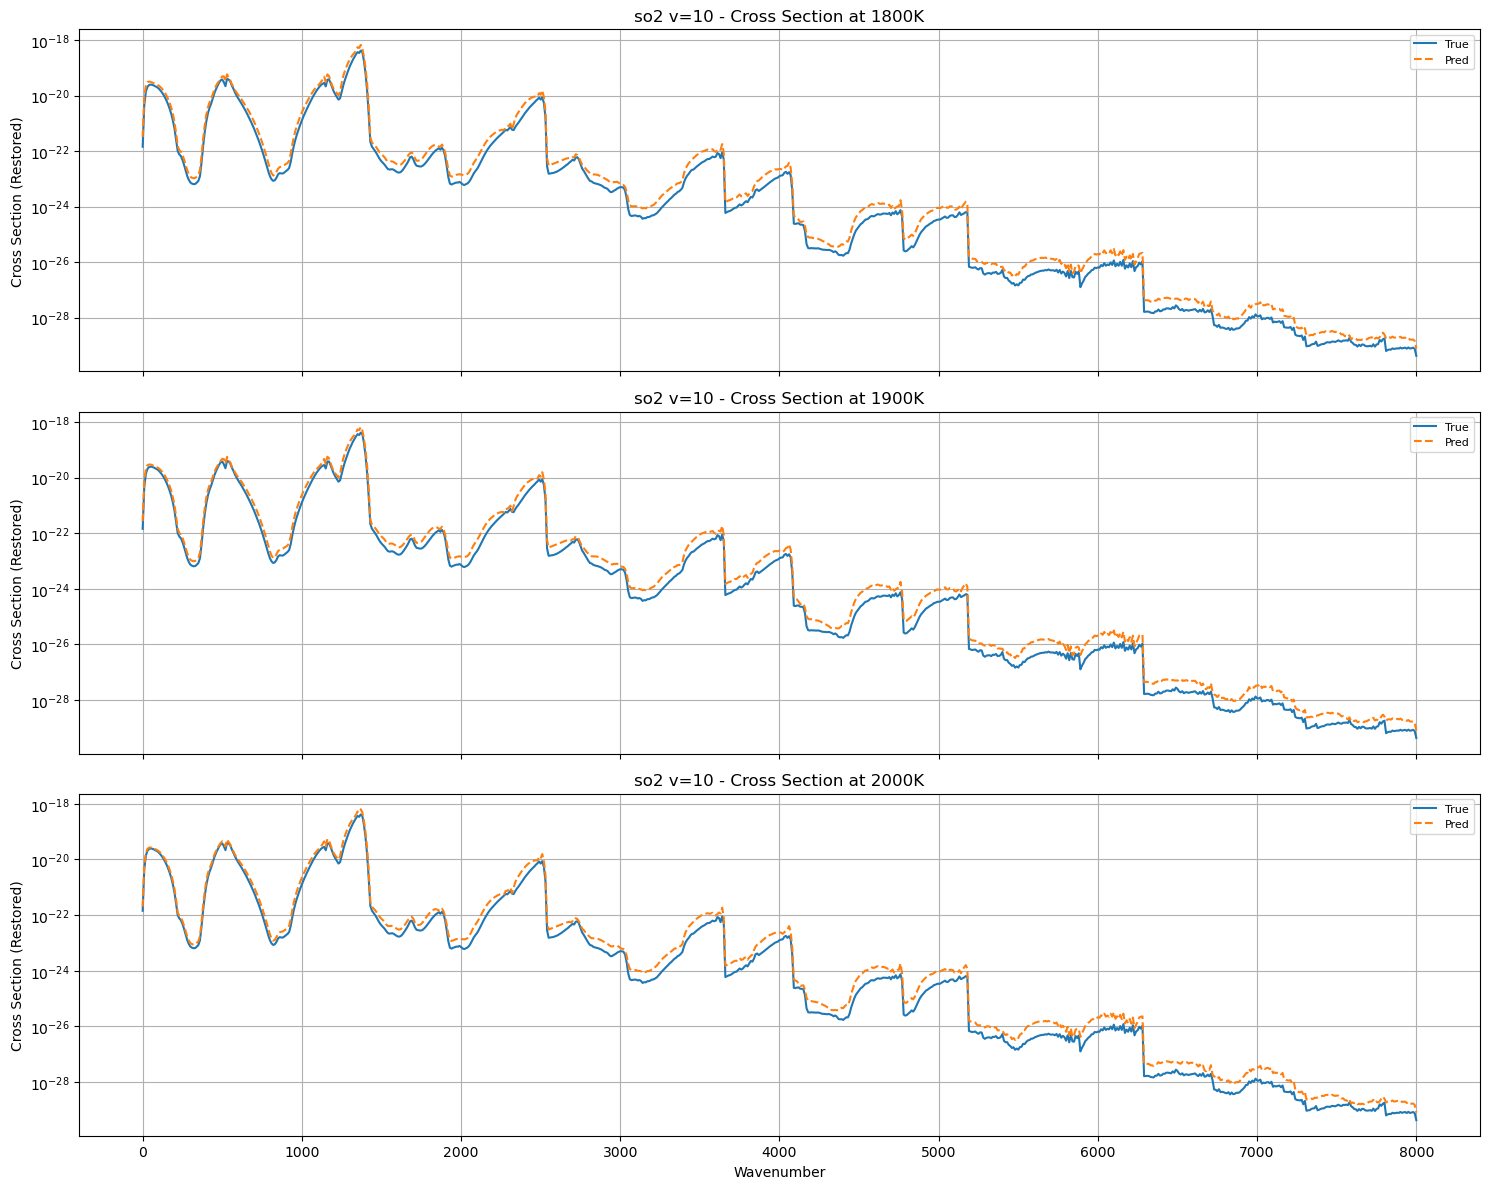

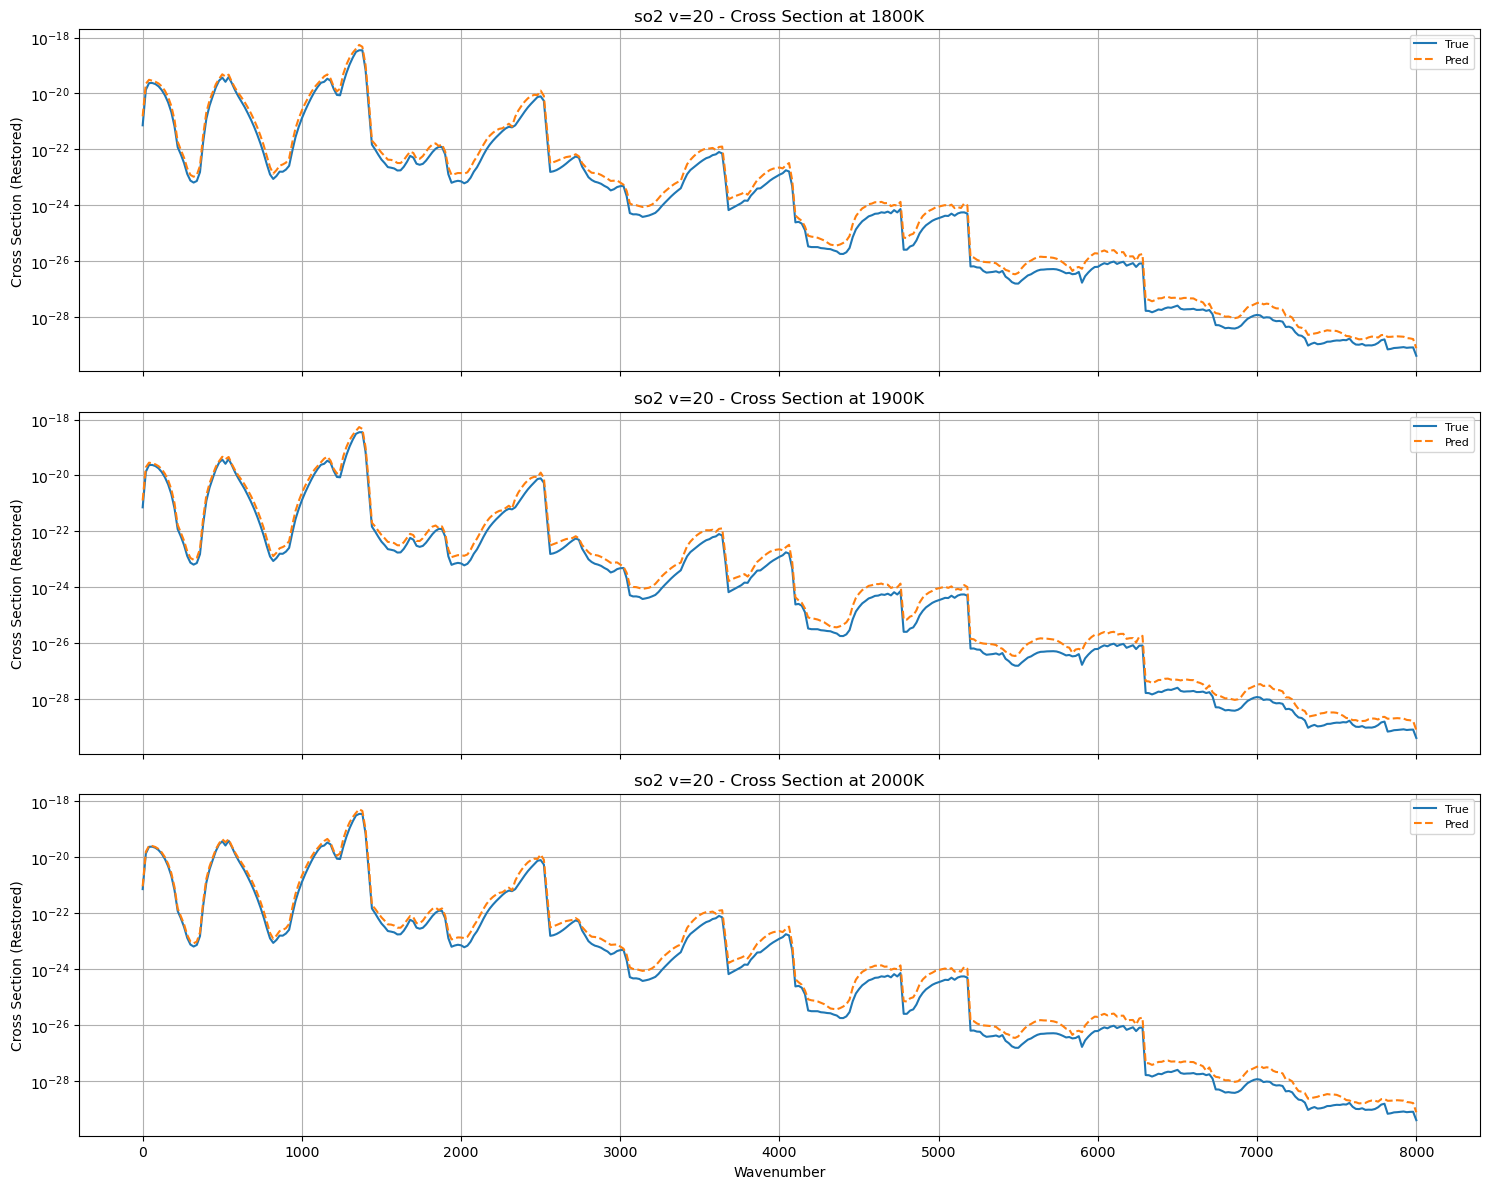

In [2]:
# ========== Draw a separate graph for each dataset==========
temps = [1800, 1900, 2000]

for name, df in results.items():
    fig, axs = plt.subplots(len(temps), 1, figsize=(15, 12), sharex=True)

    for i, temp in enumerate(temps):
        ax = axs[i]
        subset = df[df['temperature'] == temp]
        ax.plot(subset['wavenumber'], subset['cross_section_restored'], label='True')
        ax.plot(subset['wavenumber'], subset['predicted_restored'], linestyle='--', label='Pred')
        ax.set_title(f'{name} - Cross Section at {temp}K')
        ax.set_ylabel('Cross Section (Restored)')
        ax.legend(fontsize=8)
        ax.grid(True)
        ax.set_yscale('log')

    axs[-1].set_xlabel('Wavenumber')
    plt.tight_layout()
    plt.show()